In [1]:
# 1. Загрузить набор данных из репозитория. Свой выбор данных  согласовать с преподавателем.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage


df = pd.read_csv("./data/global_cancer_patients_2015_2024.csv")

print(df.info())

df = df.drop_duplicates()

df = df.drop("Patient_ID", axis=1)
df = df.drop("Treatment_Cost_USD", axis=1)
df = df.drop("Year", axis=1)

df.head()


# 5. Отобрать и определить признаки, которые будут использоваться для построения моделей.

important_feat = [
    "Age",
    "Gender",
    "Country_Region",
    "Genetic_Risk",
    "Air_Pollution",
    "Alcohol_Use",
    "Smoking",
    "Obesity_Level",
    "Cancer_Type" "Cancer_Stage",
]

numeric_columns = [
    "Age",
    "Genetic_Risk",
    "Air_Pollution",
    "Alcohol_Use",
    "Smoking",
    "Obesity_Level",
    "Survival_Years",
    "Target_Severity_Score",
]


categorical_columns = [
    "Gender",
    "Country_Region",
    "Cancer_Type",
    "Cancer_Stage",
]

target = "Cancer_type"
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  50000 non-null  float64
dtypes:

,Age,Gender,Country_Region,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Survival_Years,Target_Severity_Score
0,71,Male,UK,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,5.9,4.92
1,34,Male,China,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,4.7,4.65
2,80,Male,Pakistan,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,7.1,5.84
3,40,Male,UK,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,1.6,3.12
4,43,Female,Brazil,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,2.9,3.62


In [2]:
df_encoded = df.copy()

for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

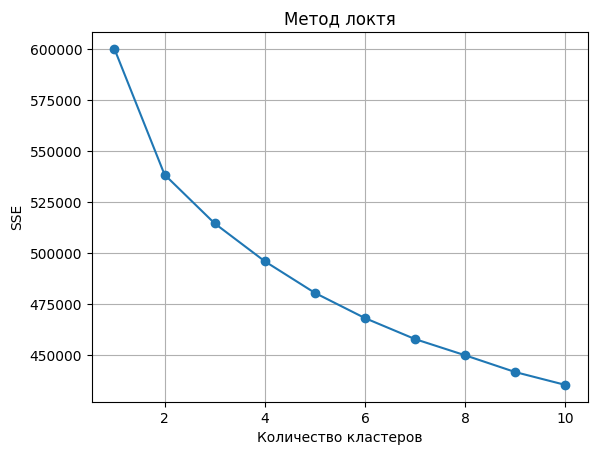

In [3]:
df_encoded.head()

# Метод локтя
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker="o")
plt.xlabel("Количество кластеров")
plt.ylabel("SSE")
plt.title("Метод локтя")
plt.grid(True)
plt.show()

# k=4
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

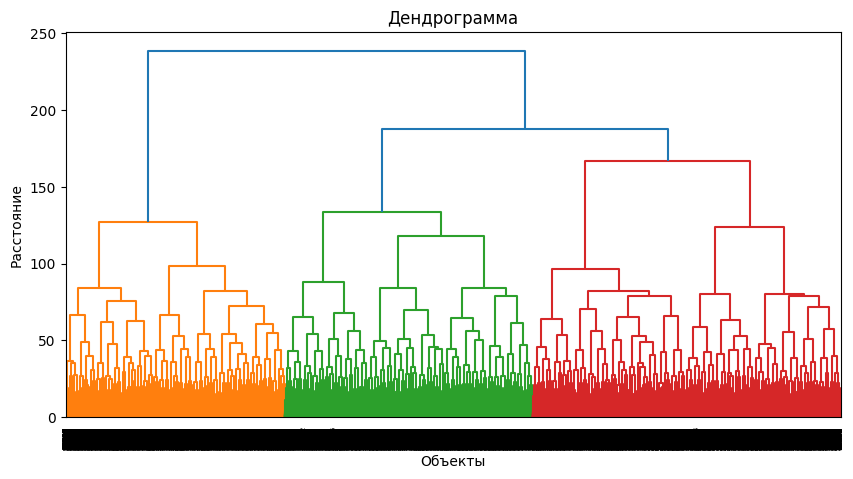

In [4]:
# Дендрограмма
linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title("Дендрограмма")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.show()

In [5]:
# 4 кластера
agglo = AgglomerativeClustering(n_clusters=4, linkage="ward")

labels_agglo = agglo.fit_predict(X_scaled)

In [6]:
# Простой подбор параметров eps и min_samples
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

In [7]:
def evaluate_clustering(X, labels):
    if len(set(labels)) > 1 and -1 not in labels:
        silhouette = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        print(
            f"Silhouette Score: {silhouette:.3f}, Davies-Bouldin Index: {db_index:.3f}"
        )
    else:
        print("Недостаточно кластеров для оценки или есть выбросы.")


print("KMeans++:")
evaluate_clustering(X_scaled, labels_kmeans)

print("Agglomerative:")
evaluate_clustering(X_scaled, labels_agglo)

print("DBSCAN:")
evaluate_clustering(X_scaled, labels_dbscan)

KMeans++:
Silhouette Score: 0.064, Davies-Bouldin Index: 2.993
Agglomerative:
Silhouette Score: 0.020, Davies-Bouldin Index: 4.088
DBSCAN:
Недостаточно кластеров для оценки или есть выбросы.


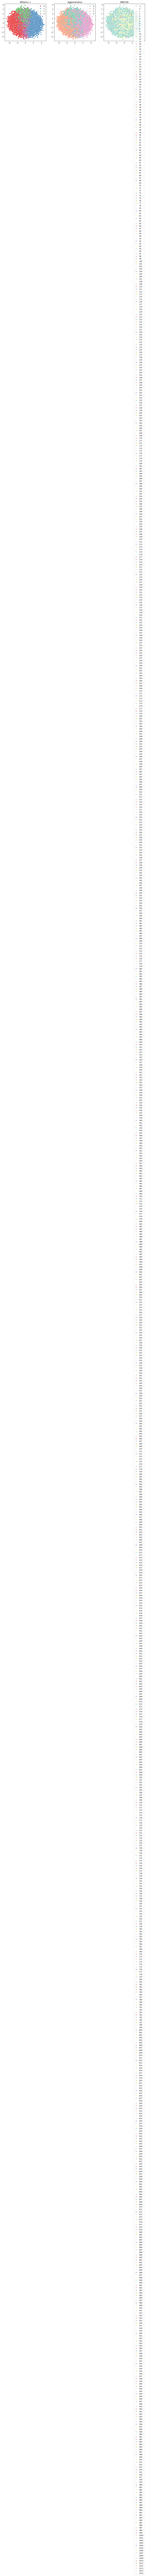

In [8]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette="Set1")
plt.title("KMeans++")

plt.subplot(1, 3, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_agglo, palette="Set2")
plt.title("Agglomerative")

plt.subplot(1, 3, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_dbscan, palette="Set3")
plt.title("DBSCAN")

plt.show()

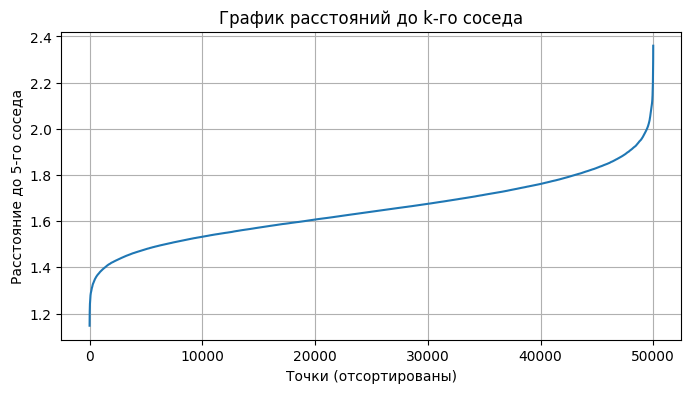

In [10]:
# Настроить разные гипперпараметры для DBSCAN
# Удалить шумывые объекты
# Использовать метрики оценки качества алгоритмов кластеризации (внутренние и внешние), коэффициент силуэта
# На основании каких признаков определены кластеры для каждого алгоритма

from sklearn.neighbors import NearestNeighbors
import numpy as np

# Построим график расстояний до k-го соседа (k = min_samples)
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, k - 1])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Точки (отсортированы)")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.title("График расстояний до k-го соседа")
plt.grid(True)
plt.show()

In [11]:
eps_values = [0.8, 1.0, 1.2, 1.5]
min_samples_values = [3, 5, 7]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(
            f"eps={eps}, min_samples={min_samples} => clusters: {n_clusters}, noise: {(labels == -1).sum()}"
        )

eps=0.8, min_samples=3 => clusters: 1, noise: 49997
eps=0.8, min_samples=5 => clusters: 0, noise: 50000
eps=0.8, min_samples=7 => clusters: 0, noise: 50000
eps=1.0, min_samples=3 => clusters: 45, noise: 49860
eps=1.0, min_samples=5 => clusters: 0, noise: 50000
eps=1.0, min_samples=7 => clusters: 0, noise: 50000
eps=1.2, min_samples=3 => clusters: 751, noise: 47479
eps=1.2, min_samples=5 => clusters: 8, noise: 49956
eps=1.2, min_samples=7 => clusters: 0, noise: 50000
eps=1.5, min_samples=3 => clusters: 1175, noise: 16170
eps=1.5, min_samples=5 => clusters: 1016, noise: 30540
eps=1.5, min_samples=7 => clusters: 536, noise: 42196


In [12]:
# Удалим шумы
labels_dbscan = dbscan.fit_predict(X_scaled)
mask_core = labels_dbscan != -1

X_dbscan_clean = X_scaled[mask_core]
labels_dbscan_clean = labels_dbscan[mask_core]

In [13]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)


def evaluate_internal(X, labels, name):
    if len(set(labels)) > 1 and -1 not in labels:
        print(f"Метрики для {name}:")
        print(f" - Silhouette Score: {silhouette_score(X, labels):.3f}")
        print(f" - Davies-Bouldin Index: {davies_bouldin_score(X, labels):.3f}")
        print(f" - Calinski-Harabasz Index: {calinski_harabasz_score(X, labels):.3f}")
    else:
        print(f"Недостаточно кластеров для оценки ({name}).")


evaluate_internal(X_scaled, labels_kmeans, "KMeans++")
evaluate_internal(X_scaled, labels_agglo, "Agglomerative")
evaluate_internal(X_dbscan_clean, labels_dbscan_clean, "DBSCAN (без шумов)")

Метрики для KMeans++:
 - Silhouette Score: 0.064
 - Davies-Bouldin Index: 2.993
 - Calinski-Harabasz Index: 3491.770
Метрики для Agglomerative:
 - Silhouette Score: 0.020
 - Davies-Bouldin Index: 4.088
 - Calinski-Harabasz Index: 1855.137
Метрики для DBSCAN (без шумов):
 - Silhouette Score: -0.023
 - Davies-Bouldin Index: 1.512
 - Calinski-Harabasz Index: 21.807


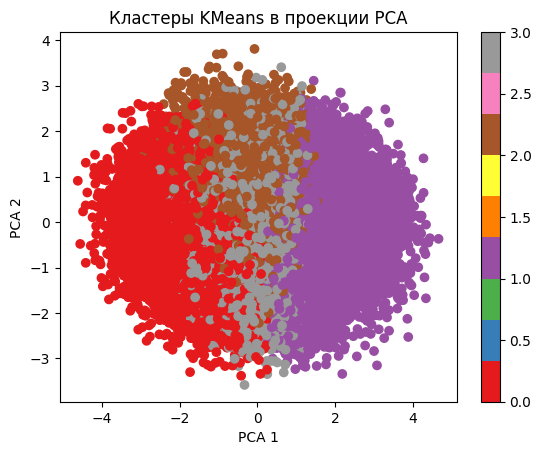

Вклад признаков в главные компоненты:
                            PC1       PC2       PC3       PC4       PC5  \
Age                   -0.001047  0.372545  0.116028  0.431135  0.353090   
Gender                -0.003884  0.253873  0.607242 -0.025064 -0.021127   
Country_Region         0.008298  0.136404  0.174607  0.655883 -0.080266   
Genetic_Risk           0.376002  0.527230 -0.267955 -0.161959 -0.305205   
Air_Pollution          0.292918 -0.218993 -0.114122 -0.150438  0.437847   
Alcohol_Use            0.288225 -0.097478  0.424320 -0.123260 -0.312455   
Smoking                0.383698 -0.074064  0.055263  0.260298  0.358156   
Obesity_Level          0.207725 -0.389041 -0.028098  0.183374 -0.292288   
Cancer_Type            0.005989 -0.433246  0.112787  0.038706  0.261653   
Cancer_Stage          -0.002152 -0.272822  0.329437  0.094470 -0.328747   
Survival_Years         0.007077 -0.153824 -0.444232  0.455396 -0.309360   
Target_Severity_Score  0.706540  0.009306  0.001020 -0.008233 

In [16]:
import pandas as pd

pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# Визуализация
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap="Set1")
plt.title("Кластеры KMeans в проекции PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.show()

# Посмотрим, какие признаки сильнее влияют на компоненты
loadings = pd.DataFrame(
    pca.components_.T, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9"], index=df_encoded.columns
)

print("Вклад признаков в главные компоненты:")
print(loadings)